<a href="https://colab.research.google.com/github/Sultan-manjur/BME/blob/main/BME/mid3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
data=pd.read_csv('training[1].csv')
test=pd.read_csv('testing[1].csv')

In [ ]:
import numpy as np
y_tt=np.array(data.Letter) # output labels of training dataset

In [ ]:
x_t=np.array(data.drop(['Letter'],axis=1)) # traning dataset featiures


In [ ]:
y_t=y_tt-1 # making the output labels 0 to 25 instead of 1 to 26.

In [ ]:
k1=np.array(test.drop(['Letter'],axis=1))   # Test data features


k22=np.array(test.Letter)    # test data output labels
k2=k22-1   # making the output labels 0 to 25 instead of 1 to 26.

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x_t,y_t,test_size=0.2,shuffle=True,stratify=y_t)

In [ ]:
import matplotlib.pyplot as plt 
import tensorflow as tf       
from tensorflow import keras 

In [ ]:
gpus= tf.config.experimental.list_physical_devices('GPU')
for gpu_instance in gpus: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)

In [ ]:
import numpy as np
def dnn_model(n_hidden=1, n_neurons=30, activation='relu',learning_rate=3e-3, input_dim=617,normalization=1,dropout=1):  # Parameter Optimization
    dnn_clf = keras.models.Sequential()
    dnn_clf.add(keras.layers.InputLayer(input_shape=input_dim))
    for layer in range(n_hidden):
        
        dnn_clf.add(keras.layers.Dense(n_neurons,activation=activation))
        if normalization==0:
          continue
        else:
          dnn_clf.add(keras.layers.BatchNormalization())
        if dropout==0:
          continue
        else:
          dnn_clf.add(keras.layers.Dropout(0.2))

    dnn_clf.add(keras.layers.Dense(26, activation="softmax"))
    optimfcn = keras.optimizers.RMSprop(learning_rate=learning_rate)
    dnn_clf.compile(loss="sparse_categorical_crossentropy", optimizer=optimfcn, metrics=["accuracy"])
    return dnn_clf

# create a wrapper to use the DNN as any other classifier in scikit-learn
clftemp = keras.wrappers.scikit_learn.KerasClassifier(dnn_model)

# set the range of parameters to test
param_distribs = {
    "n_hidden": [ 2,3,4],
    "n_neurons": np.arange(1, 100, 20).tolist(),
    "learning_rate": np.logspace(-4, -2,num=5).tolist(),
    'activation':['relu','selu','tanh'],
    'normalization':[0,1],
    'dropout':[0,1]
    
}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
search_cv = RandomizedSearchCV(clftemp, param_distribs, n_iter = 5, cv=3, verbose=0, n_jobs=1)
earlystop_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
# run the grid search
search_cv.fit(x_train,y_train,
              epochs = 30,
              validation_data = (x_test, y_test),
              verbose = 0,
              callbacks=[earlystop_cb])

52/52 [==============================] - 0s 3ms/step - loss: 0.2772 - accuracy: 0.9080


RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fe19819f790>,
                   n_iter=5, n_jobs=1,
                   param_distributions={'activation': ['relu', 'selu', 'tanh'],
                                        'dropout': [0, 1],
                                        'learning_rate': [0.0001,
                                                          0.00031622776601683794,
                                                          0.001,
                                                          0.0031622776601683794,
                                                          0.01],
                                        'n_hidden': [2, 3, 4],
                                        'n_neurons': [1, 21, 41, 61, 81],
                                        'normalization': [0, 1]})

In [ ]:
print(search_cv.best_params_)

{'normalization': 1, 'n_neurons': 81, 'n_hidden': 2, 'learning_rate': 0.00031622776601683794, 'dropout': 0, 'activation': 'selu'}


In [ ]:
print(search_cv.best_score_)

0.9442892273267111


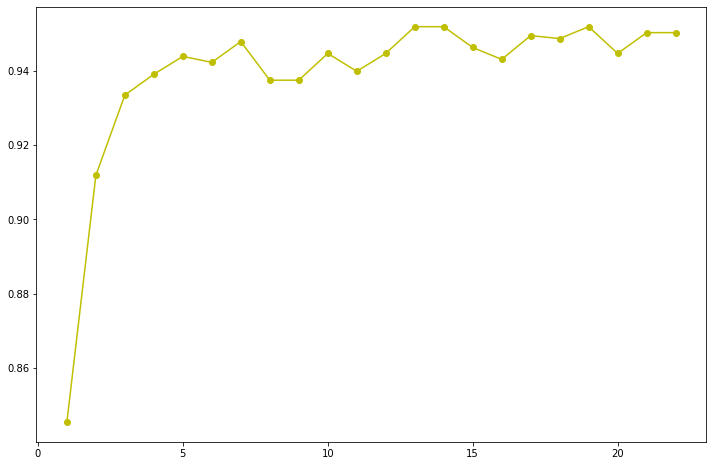

In [ ]:
optimfcn = keras.optimizers.RMSprop(learning_rate=0.00031622776601683794)

dnn_clf = keras.models.Sequential([
    keras.layers.Dense(81, activation="selu",input_dim=617),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(81, activation="selu"),

    keras.layers.Dense(26, activation="softmax")
])

dnn_clf.compile(loss="sparse_categorical_crossentropy",
                optimizer=optimfcn,
                metrics=["accuracy"])
n_epochs = 40
earlystop_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
training = dnn_clf.fit(x_train, y_train, epochs=100,verbose=0,
                      validation_data=(x_test, y_test),callbacks=[earlystop_cb])
accuracy_score = training.history.get('val_accuracy')
plt.figure(figsize=(12,8))
plt.plot(range(1,len(accuracy_score)+1), accuracy_score, color='y', marker='o',label='2 layer DNN')

In [ ]:
score = dnn_clf.evaluate(k1,k2,verbose=1)
print(score[1])

49/49 [==============================] - 0s 3ms/step - loss: 0.2218 - accuracy: 0.9448
0.944836437702179


In [ ]:
pred_prob1=dnn_clf.predict(k1)
pred1=[]
for vals in pred_prob1:
  pred1.append(np.argmax(vals))
from sklearn.metrics import classification_report
print(classification_report(k2,np.array(pred1)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        60
           1       0.92      0.82      0.87        60
           2       0.98      1.00      0.99        60
           3       0.88      0.95      0.91        60
           4       0.81      1.00      0.90        60
           5       0.94      0.97      0.95        60
           6       0.87      1.00      0.93        60
           7       1.00      0.98      0.99        60
           8       1.00      0.95      0.97        60
           9       0.98      0.98      0.98        60
          10       0.97      0.98      0.98        60
          11       0.97      1.00      0.98        60
          12       0.86      0.81      0.83        59
          13       0.80      0.80      0.80        60
          14       1.00      0.98      0.99        60
          15       0.98      0.87      0.92        60
          16       1.00      1.00      1.00        60
          17       0.94    

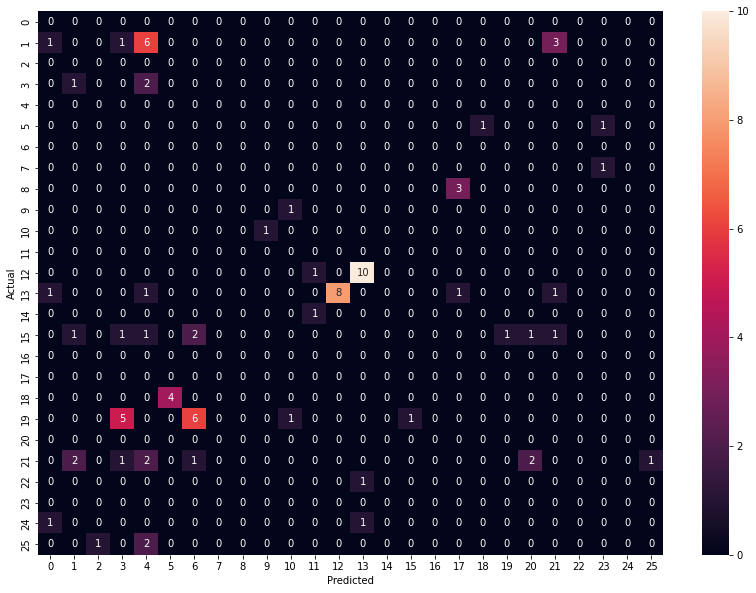

In [ ]:
import matplotlib.pyplot as plt
import seaborn
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(k2, np.array(pred1))
np.fill_diagonal(conf_mat, 0)
plt.figure(figsize=(14,10))
seaborn.heatmap(conf_mat, annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
from sklearn.preprocessing import label_binarize
binarized_data=label_binarize(np.array(k2), classes=list((np.ceil(np.linspace(0,25,26))).astype(int)))

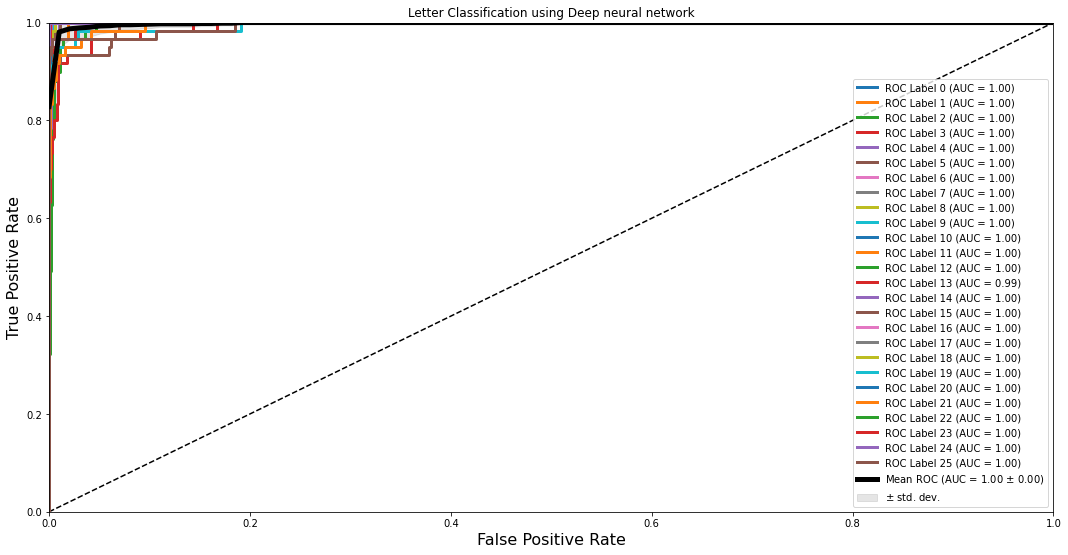

In [ ]:
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
Fpr_mean = np.linspace(0, 1, 100)
tpr_mean = []
Fpr = []
Tpr = []
AUC = []

for i in range(26):# I have 26 class labels
  fpr, tpr, T = roc_curve(binarized_data[:,i],pred_prob1[:,i])
  AUC.append(roc_auc_score(binarized_data[:,i],pred_prob1[:,i]))
  Fpr.append(fpr)
  Tpr.append(tpr)
# add an interpolated version of Tpr for the mean ROC curve
  tpr_mean.append(np.interp(Fpr_mean, fpr, tpr))
Tpr_mean = np.mean(tpr_mean, axis=0)
Tpr_stdv = np.std(tpr_mean, axis=0)
mean_auc = auc(Fpr_mean, Tpr_mean)
std_auc = np.std(AUC)
plt.figure(1, figsize=(18, 9))
plt.clf()
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Letter Classification using Deep neural network')
# plot the individual ROC curves

for w in range(26):
  plt.plot(Fpr[w],Tpr[w], linewidth=3, label=r'ROC Label %d (AUC = %0.2f)' % (w,AUC[w]))
# plot the average ROC curve
plt.plot(Fpr_mean, Tpr_mean, color='k', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), linewidth=5)
# plot the backround +/- SD around the average ROC curve
UB = np.minimum(Tpr_mean + Tpr_stdv, 1)
LB = np.maximum(Tpr_mean - Tpr_stdv, 0)
plt.fill_between(Fpr_mean, LB, UB, color='grey', alpha=0.2, label=r'$\pm$ std. dev.')
plt.legend(loc="lower right")

In [ ]:
x_train = x_train[...,np.newaxis] # converting it to a tensor
k1=k1[...,np.newaxis] 
x_test=x_test[...,np.newaxis]


In [ ]:
import numpy as np
def cnn_model(filters=32,n_hidden=1, n_neurons=30, activation='relu',learning_rate=3e-3, input_dim=617,normalization=1,dropout=1):
    cnn_clf = keras.models.Sequential()
    cnn_clf.add(keras.layers.Conv1D(filters=filters, kernel_size=4, activation=activation, padding="same",strides=1, input_shape=[617,1])),
    cnn_clf.add(keras.layers.Flatten()),
    for layer in range(n_hidden):
        
        cnn_clf.add(keras.layers.Dense(n_neurons,activation=activation))
        if normalization==0:
          continue
        else:
          cnn_clf.add(keras.layers.BatchNormalization())
        if dropout==0:
          continue
        else:
          cnn_clf.add(keras.layers.Dropout(0.2))

    cnn_clf.add(keras.layers.Dense(26, activation="softmax"))
    optimfcn = keras.optimizers.RMSprop(learning_rate=learning_rate)
    cnn_clf.compile(loss="sparse_categorical_crossentropy", optimizer=optimfcn, metrics=["accuracy"])
    return cnn_clf

# create a wrapper to use the DNN as any other classifier in scikit-learn
clftemp = keras.wrappers.scikit_learn.KerasClassifier(cnn_model)

# set the range of parameters to test
param_distribs = {
    "n_hidden": [ 2,3,4],
    "n_neurons": np.arange(1, 100, 20).tolist(),
    "learning_rate": np.logspace(-4, -2,num=5).tolist(),
    'activation':['relu','selu','tanh'],
    'filters':np.arange(1, 100, 20).tolist(),
    'normalization':[0,1],
    'dropout':[0,1]
}





/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
search_cv = RandomizedSearchCV(clftemp, param_distribs, n_iter = 5, cv=3, verbose=0, n_jobs=1)
earlystop_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
# run the grid search
search_cv.fit(x_train,y_train,
              epochs =30 ,
              validation_data = (x_test, y_test),
              verbose = 0,
              callbacks=[earlystop_cb])

52/52 [==============================] - 0s 3ms/step - loss: 0.3654 - accuracy: 0.9104


RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fe102eef050>,
                   n_iter=5, n_jobs=1,
                   param_distributions={'activation': ['relu', 'selu', 'tanh'],
                                        'dropout': [0, 1],
                                        'filters': [1, 21, 41, 61, 81],
                                        'learning_rate': [0.0001,
                                                          0.00031622776601683794,
                                                          0.001,
                                                          0.0031622776601683794,
                                                          0.01],
                                        'n_hidden': [2, 3, 4],
                                        'n_neurons': [1, 21, 41, 61, 81],
                                        'normalization': [0, 1]})

In [ ]:
print(search_cv.best_score_)

0.9322634736696879


In [ ]:
print(search_cv.best_params_)

{'normalization': 0, 'n_neurons': 61, 'n_hidden': 2, 'learning_rate': 0.0031622776601683794, 'filters': 81, 'dropout': 0, 'activation': 'relu'}


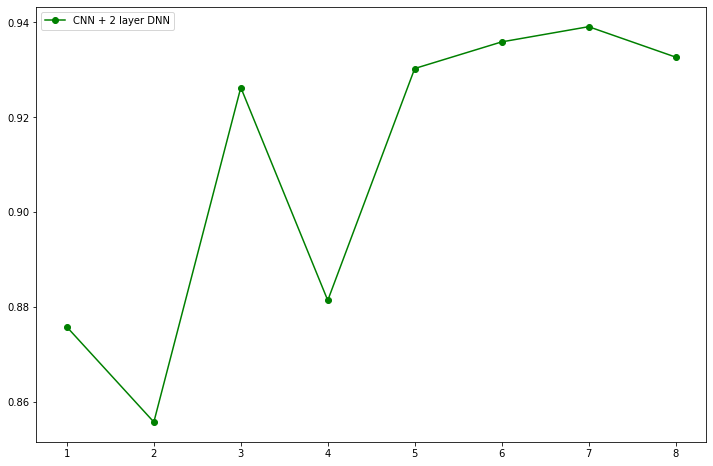

In [ ]:
optimfcn = keras.optimizers.RMSprop(learning_rate=0.0031622776601683794)

cnn_clf = keras.models.Sequential([
    keras.layers.Conv1D(filters=81, kernel_size=4, activation='relu', padding="same",strides=1, input_shape=[617,1]),
    
    keras.layers.Flatten(),
    keras.layers.Dense(61, activation="relu"),
    
    keras.layers.Dense(61, activation="relu"),
    keras.layers.Dense(26, activation="softmax")
])

cnn_clf.compile(loss="sparse_categorical_crossentropy",
                optimizer=optimfcn,
                metrics=["accuracy"])

earlystop_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
training2 = cnn_clf.fit(x_train, y_train, epochs=100,verbose=0,
                      validation_data=(x_test, y_test),callbacks=[earlystop_cb])
accuracy_score2 = training2.history.get('val_accuracy')
plt.figure(figsize=(12,8))
plt.plot(range(1,len(accuracy_score2)+1), accuracy_score2, color='g', marker='o',label='CNN + 2 layer DNN')
plt.legend()

In [ ]:
score = cnn_clf.evaluate(k1,k2,verbose=1)
print(score[1])

49/49 [==============================] - 0s 3ms/step - loss: 0.2890 - accuracy: 0.9352
0.9352148771286011


In [ ]:
pred_prob1=cnn_clf.predict(k1)
pred1=[]
for vals in pred_prob1:
  pred1.append(np.argmax(vals))
from sklearn.metrics import classification_report
print(classification_report(k2,np.array(pred1)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        60
           1       0.85      0.88      0.87        60
           2       0.98      1.00      0.99        60
           3       0.95      0.90      0.92        60
           4       0.78      0.98      0.87        60
           5       1.00      0.88      0.94        60
           6       1.00      0.93      0.97        60
           7       1.00      1.00      1.00        60
           8       1.00      0.88      0.94        60
           9       0.92      1.00      0.96        60
          10       1.00      0.95      0.97        60
          11       1.00      0.98      0.99        60
          12       0.88      0.88      0.88        59
          13       0.86      0.85      0.86        60
          14       0.98      1.00      0.99        60
          15       0.93      0.88      0.91        60
          16       1.00      0.97      0.98        60
          17       0.90    

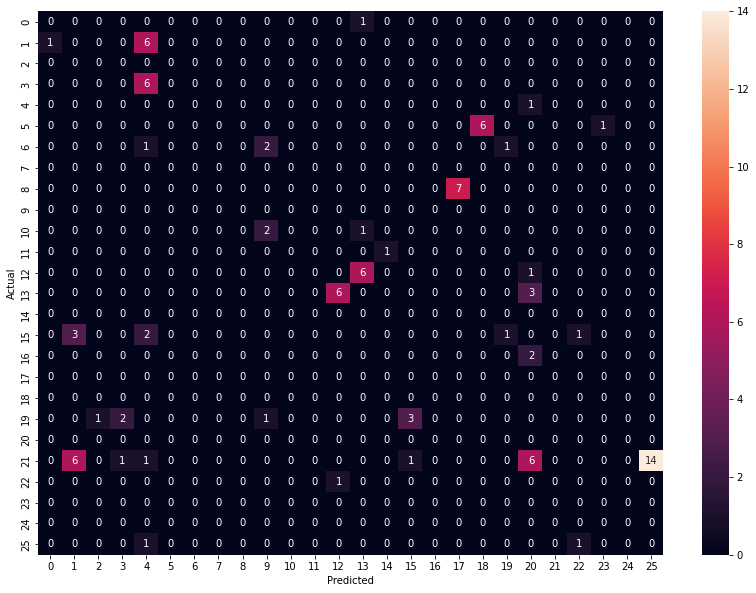

In [ ]:
import matplotlib.pyplot as plt
import seaborn
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(k2, np.array(pred1))
np.fill_diagonal(conf_mat, 0)
plt.figure(figsize=(14,10))
seaborn.heatmap(conf_mat, annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

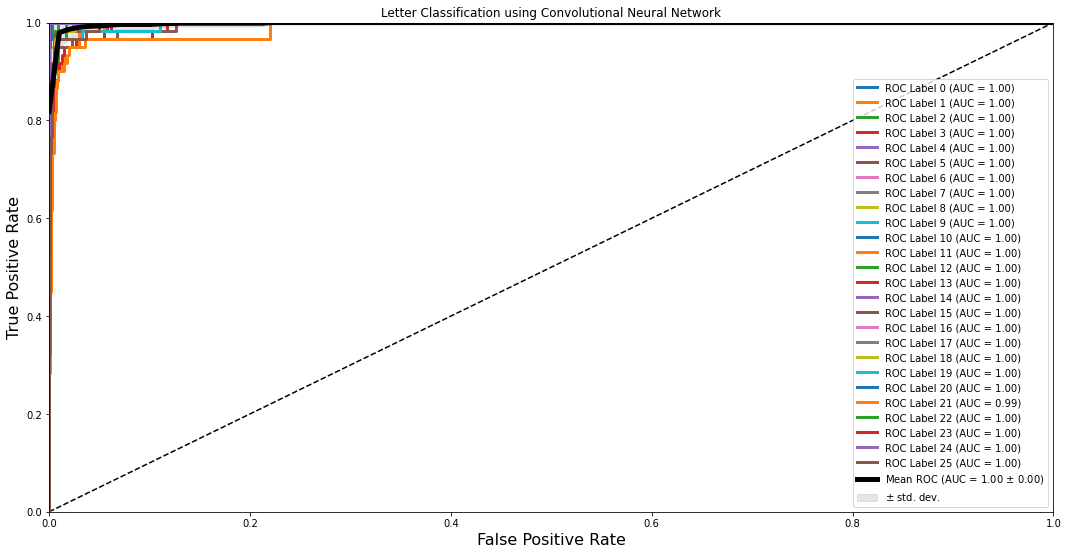

In [ ]:
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
Fpr_mean = np.linspace(0, 1, 100)
tpr_mean = []
Fpr = []
Tpr = []
AUC = []

for i in range(26):# I have 26 class labels
  fpr, tpr, T = roc_curve(binarized_data[:,i],pred_prob1[:,i])
  AUC.append(roc_auc_score(binarized_data[:,i],pred_prob1[:,i]))
  Fpr.append(fpr)
  Tpr.append(tpr)
# add an interpolated version of Tpr for the mean ROC curve
  tpr_mean.append(np.interp(Fpr_mean, fpr, tpr))
Tpr_mean = np.mean(tpr_mean, axis=0)
Tpr_stdv = np.std(tpr_mean, axis=0)
mean_auc = auc(Fpr_mean, Tpr_mean)
std_auc = np.std(AUC)
plt.figure(1, figsize=(18, 9))
plt.clf()
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Letter Classification using Convolutional Neural Network')
# plot the individual ROC curves

for w in range(26):
  plt.plot(Fpr[w],Tpr[w], linewidth=3, label=r'ROC Label %d (AUC = %0.2f)' % (w,AUC[w]))
# plot the average ROC curve
plt.plot(Fpr_mean, Tpr_mean, color='k', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), linewidth=5)
# plot the backround +/- SD around the average ROC curve
UB = np.minimum(Tpr_mean + Tpr_stdv, 1)
LB = np.maximum(Tpr_mean - Tpr_stdv, 0)
plt.fill_between(Fpr_mean, LB, UB, color='grey', alpha=0.2, label=r'$\pm$ std. dev.')
plt.legend(loc="lower right")

** PCA needs 2d array. So I went above in the code and used x_train,  x_test  and k1 arrays without adding a new axis.**

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
pcaval = PCA()
pcaval.fit(x_train)
CUMSUM = np.cumsum(pcaval.explained_variance_ratio_)
n_min = np.argmax(CUMSUM >= 0.95) + 1
print(n_min,"components of the total", len(CUMSUM), "components account for 95% of variance")

169 components of the total 617 components account for 95% of variance


In [ ]:
pcaval = PCA(n_components = 169)
x_train_pca = pcaval.fit_transform(x_train)   
x_test_pca=pcaval.fit_transform(x_test)
k1_pca=pcaval.fit_transform(k1)



In [ ]:
x_train_pca.shape

(4990, 169, 1)

In [ ]:
import numpy as np
def dnn_model(n_hidden=1, n_neurons=30, activation='relu',learning_rate=3e-3, input_dim=169,normalization=1,dropout=1):  # Parameter Optimization
    dnn_clf = keras.models.Sequential()
    dnn_clf.add(keras.layers.InputLayer(input_shape=input_dim))
    for layer in range(n_hidden):
        
        dnn_clf.add(keras.layers.Dense(n_neurons,activation=activation))
        if normalization==0:
          continue
        else:
          dnn_clf.add(keras.layers.BatchNormalization())
        if dropout==0:
          continue
        else:
          dnn_clf.add(keras.layers.Dropout(0.2))

    dnn_clf.add(keras.layers.Dense(26, activation="softmax"))
    optimfcn = keras.optimizers.RMSprop(learning_rate=learning_rate)
    dnn_clf.compile(loss="sparse_categorical_crossentropy", optimizer=optimfcn, metrics=["accuracy"])
    return dnn_clf

# create a wrapper to use the DNN as any other classifier in scikit-learn
clftemp = keras.wrappers.scikit_learn.KerasClassifier(dnn_model)

# set the range of parameters to test
param_distribs = {
    "n_hidden": [ 2,3,4],
    "n_neurons": np.arange(1, 100, 20).tolist(),
    "learning_rate": np.logspace(-4, -2,num=5).tolist(),
    'activation':['relu','selu','tanh'],
    'normalization':[0,1],
    'dropout':[0,1]
    
}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
search_cv = RandomizedSearchCV(clftemp, param_distribs, n_iter = 5, cv=3, verbose=0, n_jobs=1)
earlystop_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
# run the grid search
search_cv.fit(x_train_pca,y_train,
              epochs =30 ,
              validation_data = (x_test_pca, y_test),
              verbose = 0,
              callbacks=[earlystop_cb])

52/52 [==============================] - 0s 3ms/step - loss: 0.2905 - accuracy: 0.9284


RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fe1021660d0>,
                   n_iter=5, n_jobs=1,
                   param_distributions={'activation': ['relu', 'selu', 'tanh'],
                                        'dropout': [0, 1],
                                        'learning_rate': [0.0001,
                                                          0.00031622776601683794,
                                                          0.001,
                                                          0.0031622776601683794,
                                                          0.01],
                                        'n_hidden': [2, 3, 4],
                                        'n_neurons': [1, 21, 41, 61, 81],
                                        'normalization': [0, 1]})

In [ ]:
print(search_cv.best_params_)

{'normalization': 1, 'n_neurons': 81, 'n_hidden': 2, 'learning_rate': 0.0001, 'dropout': 0, 'activation': 'tanh'}


In [ ]:
print(search_cv.best_score_)

0.9288570880889893


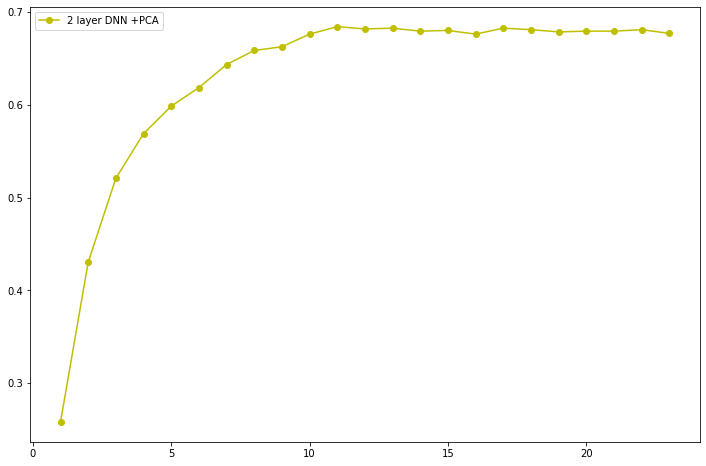

In [ ]:
optimfcn = keras.optimizers.RMSprop(learning_rate=0.0001)

dnn_clf = keras.models.Sequential([
    keras.layers.Dense(81, activation="tanh",input_dim=169),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(81, activation="tanh"),
    
    keras.layers.Dense(26, activation="softmax")
])

dnn_clf.compile(loss="sparse_categorical_crossentropy",
                optimizer=optimfcn,
                metrics=["accuracy"])
n_epochs = 40
earlystop_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
training3 = dnn_clf.fit(x_train_pca, y_train, epochs=100,verbose=0,
                      validation_data=(x_test_pca, y_test),callbacks=[earlystop_cb])
accuracy_score3 = training3.history.get('val_accuracy')
plt.figure(figsize=(12,8))
plt.plot(range(1,len(accuracy_score3)+1), accuracy_score3, color='y', marker='o',label='2 layer DNN +PCA')
plt.legend()

In [ ]:
scores=dnn_clf.evaluate(k1_pca,k2)

49/49 [==============================] - 0s 4ms/step - loss: 2.1871 - accuracy: 0.3515


In [ ]:
pred_prob1=cnn_clf.predict(k1_pca)
pred1=[]
for vals in pred_prob1:
  pred1.append(np.argmax(vals))
from sklearn.metrics import classification_report
print(classification_report(k2,np.array(pred1)))

              precision    recall  f1-score   support

           0       0.27      0.25      0.26        60
           1       0.12      0.12      0.12        60
           2       0.08      0.08      0.08        60
           3       0.10      0.07      0.08        60
           4       0.30      0.47      0.37        60
           5       0.41      0.20      0.27        60
           6       0.12      0.15      0.13        60
           7       0.11      0.07      0.08        60
           8       0.36      0.22      0.27        60
           9       0.08      0.08      0.08        60
          10       0.19      0.27      0.22        60
          11       0.34      0.35      0.34        60
          12       0.06      0.05      0.06        59
          13       0.11      0.07      0.08        60
          14       0.30      0.32      0.31        60
          15       0.08      0.05      0.06        60
          16       0.46      0.57      0.51        60
          17       0.67    

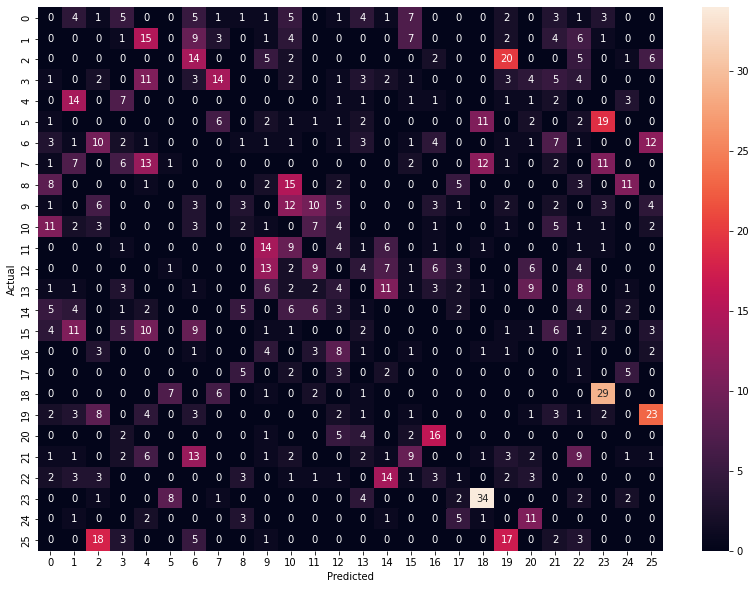

In [ ]:
import matplotlib.pyplot as plt
import seaborn
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(k2, np.array(pred1))
np.fill_diagonal(conf_mat, 0)
plt.figure(figsize=(14,10))
seaborn.heatmap(conf_mat, annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

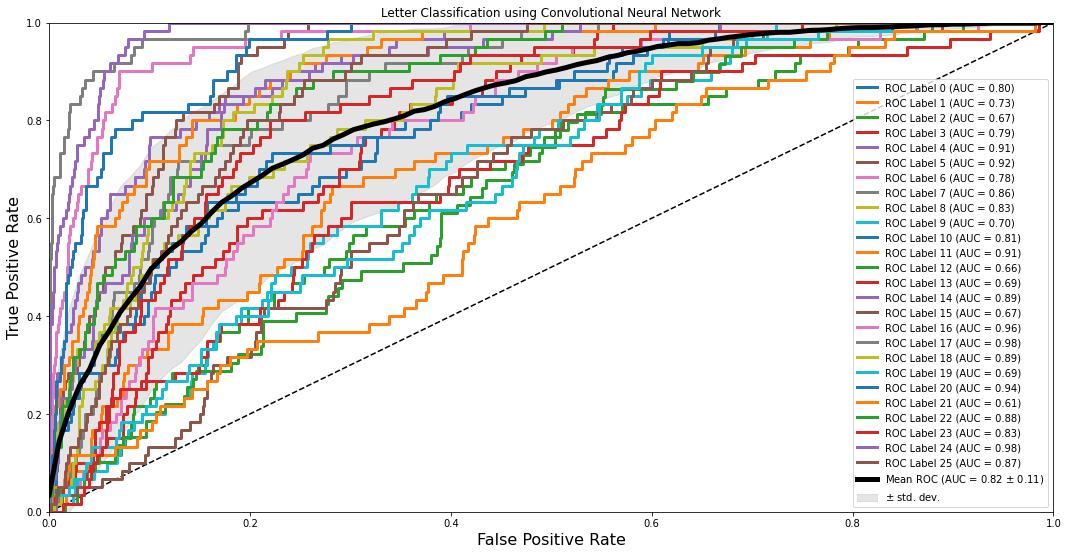

In [ ]:
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
Fpr_mean = np.linspace(0, 1, 100)
tpr_mean = []
Fpr = []
Tpr = []
AUC = []

for i in range(26):# I have 26 class labels
  fpr, tpr, T = roc_curve(binarized_data[:,i],pred_prob1[:,i])
  AUC.append(roc_auc_score(binarized_data[:,i],pred_prob1[:,i]))
  Fpr.append(fpr)
  Tpr.append(tpr)
# add an interpolated version of Tpr for the mean ROC curve
  tpr_mean.append(np.interp(Fpr_mean, fpr, tpr))
Tpr_mean = np.mean(tpr_mean, axis=0)
Tpr_stdv = np.std(tpr_mean, axis=0)
mean_auc = auc(Fpr_mean, Tpr_mean)
std_auc = np.std(AUC)
plt.figure(1, figsize=(18, 9))
plt.clf()
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Letter Classification using Convolutional Neural Network')
# plot the individual ROC curves

for w in range(26):
  plt.plot(Fpr[w],Tpr[w], linewidth=3, label=r'ROC Label %d (AUC = %0.2f)' % (w,AUC[w]))
# plot the average ROC curve
plt.plot(Fpr_mean, Tpr_mean, color='k', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), linewidth=5)
# plot the backround +/- SD around the average ROC curve
UB = np.minimum(Tpr_mean + Tpr_stdv, 1)
LB = np.maximum(Tpr_mean - Tpr_stdv, 0)
plt.fill_between(Fpr_mean, LB, UB, color='grey', alpha=0.2, label=r'$\pm$ std. dev.')
plt.legend(loc="lower right")

In [ ]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
knn=KNeighborsClassifier()
param1={'n_neighbors':range(2,20),'weights':['uniform','distance'],'p':[1,2]}

search1=RandomizedSearchCV(knn,param1,cv=5,n_jobs=-1)
search1.fit(x_t,y_t)
print(search1.best_params_)


{'weights': 'distance', 'p': 2, 'n_neighbors': 6}


In [ ]:
print(search1.best_score_)

0.9190462237575309


In [ ]:
from sklearn.svm import SVC

svm=SVC()
param2={'C':[0.5,0.6,0.7,0.8,0.9,1,1.2,1.3,1.5],'kernel':['linear','rbf','poly']}
search2=RandomizedSearchCV(svm,param2,cv=5,n_jobs=-1)
search2.fit(x_t,y_t)
print(search2.best_params_)


{'kernel': 'poly', 'C': 1.5}


In [ ]:
print(search2.best_score_)

0.9637721557378734


In [ ]:
from sklearn.ensemble import VotingClassifier
KNN=KNeighborsClassifier(n_neighbors=6, weights='distance',p=2)
SVM=SVC(C=1.5,kernel='poly',probability=True)
vote= VotingClassifier(estimators=[('knn', KNN ), ('svm', SVM)],voting='soft')
vote.fit(x_t,y_t)
pred1=vote.predict(k1)
pred_prob1=vote.predict_proba(k1)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(k2,np.array(pred1)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        60
           1       0.88      0.88      0.88        60
           2       0.95      0.98      0.97        60
           3       0.98      0.93      0.96        60
           4       0.89      0.95      0.92        60
           5       0.94      1.00      0.97        60
           6       0.97      1.00      0.98        60
           7       1.00      1.00      1.00        60
           8       1.00      1.00      1.00        60
           9       0.98      1.00      0.99        60
          10       0.97      0.98      0.98        60
          11       0.98      1.00      0.99        60
          12       0.89      0.92      0.90        59
          13       0.96      0.85      0.90        60
          14       1.00      1.00      1.00        60
          15       0.95      0.90      0.92        60
          16       0.97      1.00      0.98        60
          17       1.00    

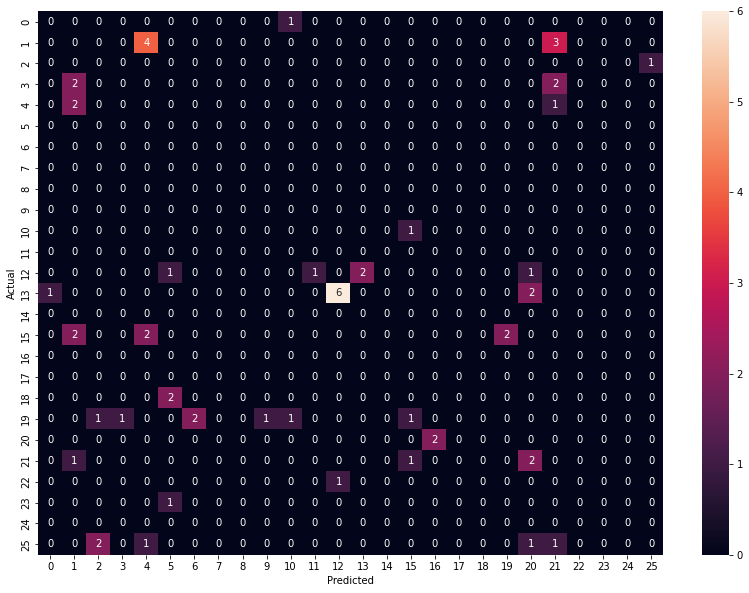

In [ ]:
import matplotlib.pyplot as plt
import seaborn
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(k2, np.array(pred1))
np.fill_diagonal(conf_mat, 0)
plt.figure(figsize=(14,10))
seaborn.heatmap(conf_mat, annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

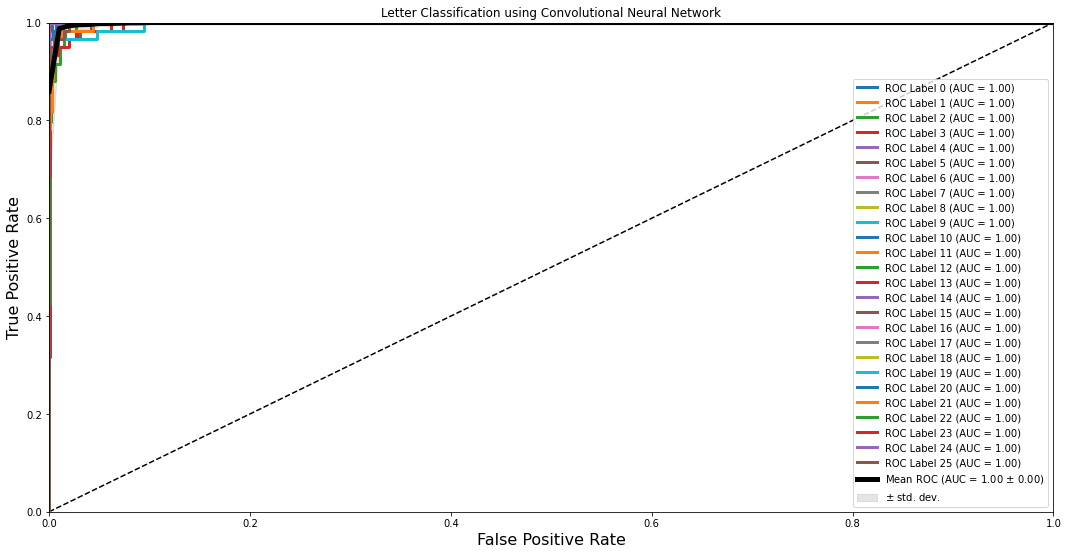

In [ ]:
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
Fpr_mean = np.linspace(0, 1, 100)
tpr_mean = []
Fpr = []
Tpr = []
AUC = []

for i in range(26):# I have 26 class labels
  fpr, tpr, T = roc_curve(binarized_data[:,i],pred_prob1[:,i])
  AUC.append(roc_auc_score(binarized_data[:,i],pred_prob1[:,i]))
  Fpr.append(fpr)
  Tpr.append(tpr)
# add an interpolated version of Tpr for the mean ROC curve
  tpr_mean.append(np.interp(Fpr_mean, fpr, tpr))
Tpr_mean = np.mean(tpr_mean, axis=0)
Tpr_stdv = np.std(tpr_mean, axis=0)
mean_auc = auc(Fpr_mean, Tpr_mean)
std_auc = np.std(AUC)
plt.figure(1, figsize=(18, 9))
plt.clf()
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Letter Classification using Convolutional Neural Network')
# plot the individual ROC curves

for w in range(26):
  plt.plot(Fpr[w],Tpr[w], linewidth=3, label=r'ROC Label %d (AUC = %0.2f)' % (w,AUC[w]))
# plot the average ROC curve
plt.plot(Fpr_mean, Tpr_mean, color='k', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), linewidth=5)
# plot the backround +/- SD around the average ROC curve
UB = np.minimum(Tpr_mean + Tpr_stdv, 1)
LB = np.maximum(Tpr_mean - Tpr_stdv, 0)
plt.fill_between(Fpr_mean, LB, UB, color='grey', alpha=0.2, label=r'$\pm$ std. dev.')
plt.legend(loc="lower right")